# TRANSFORMACIÓN DE DATOS

## IMPORTAR PAQUETES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import Binarizer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import MinMaxScaler

#Automcompletar rápido
%config IPCompleter.greedy=True

## IMPORTAR LOS DATOS

1.- Sustituir la ruta del proyecto.

In [2]:
ruta_proyecto ='C:/Users/Ana/Desktop/DATA_SCIENCE_FOR_BUSINESS/PYTHON_DATA_SCIENCE_MASTERY/EstructuraDirectorio/03_MACHINE_LEARNING/08_CASOS_/03_SCORING RIESGOS'

2.- Nombrar los ficheros de datos.

In [3]:
nombre_cat = 'cat_resultado_eda.pickle'
nombre_num = 'num_resultado_eda.pickle'

3.- Cargar los datos.

In [4]:
cat = pd.read_pickle(ruta_proyecto + '/02_Datos/03_Trabajo/' + nombre_cat)
num = pd.read_pickle(ruta_proyecto + '/02_Datos/03_Trabajo/' + nombre_num)

Recordamos lo que habíamos identificado en fases anteriores y lo organizamos por tipo de acción.

Modificar con pandas/numpy:

* Crear la target a partir de estado
* Discretizar num_meses_desde_ult_retraso
* En vivienda juntar NONE y OTHER
* En finalidad juntar renewable_energy, educational y vacation en 'otros'

Modificar con scikit learn:

* La variable descripcion podríamos trabajarla con un TF-IDF Vectorizer
* Convertir num_derogatorios a binaria

## CREACIÓN DE VARIABLES Y TRANSFORMACIONES CON PANDAS

### Target para el modelo PD

Crear la target a partir de estado

In [5]:
cat.estado.value_counts()

estado
Fully Paid                                             66322
Current                                                54062
Charged Off                                            16396
Late (31-120 days)                                      1316
In Grace Period                                          531
Late (16-30 days)                                        271
Does not meet the credit policy. Status:Fully Paid       106
Does not meet the credit policy. Status:Charged Off       50
Default                                                    3
Name: count, dtype: int64

In [6]:
cat['target_pd'] = np.where(cat.estado.isin(['Charged Off','Does not meet the credit policy. Status:Charged Off','Default']), 1, 0)
cat

,empleo,antigüedad_empleo,ingresos_verificados,rating,vivienda,descripcion,finalidad,num_cuotas,estado,target_pd
id_cliente,,,,,,,,,,
137387967,Hvac technician,3 years,Source Verified,A,MORTGAGE,desconocido,debt_consolidation,36 months,Current,0
46641215,Banker,5 years,Verified,A,RENT,desconocido,debt_consolidation,36 months,Fully Paid,0
87998444,executive director,9 years,Source Verified,B,MORTGAGE,desconocido,credit_card,60 months,Current,0
131289518,desconocido,10+ years,Source Verified,D,MORTGAGE,desconocido,home_improvement,60 months,Current,0
77861711,Correctional officer,10+ years,Verified,C,MORTGAGE,desconocido,debt_consolidation,36 months,Charged Off,1
...,...,...,...,...,...,...,...,...,...,...
129396054,Field Manager,10+ years,Source Verified,D,OWN,desconocido,debt_consolidation,60 months,Current,0
51876926,Office Manager,10+ years,Not Verified,C,MORTGAGE,desconocido,debt_consolidation,36 months,Fully Paid,0
121031962,Owner & President,6 years,Verified,B,MORTGAGE,desconocido,other,36 months,Current,0


In [7]:
cat.drop(columns='estado',inplace=True)

### Target para el modelo EAD

Será el porcentaje del principal que no había sido amortizado.

Por tanto: pendiente / principal

Primero tenemos que construir el pendiente como el principal menos el amortizado.

In [8]:
num['pendiente'] = num.principal - num.imp_amortizado
num

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,num_meses_desde_ult_retraso,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,pendiente
id_cliente,,,,,,,,,,,,,,,
137387967,54000.0,19.31,2.0,10.0,33.3,45.2,0.0,0.0,10.0,15000.0,7.21,464.60,2669.06,0.00,12330.94
46641215,135000.0,14.68,0.0,19.0,0.0,16.3,0.0,0.0,0.0,24000.0,6.39,734.38,24000.00,0.00,0.00
87998444,188000.0,11.69,3.0,15.0,0.0,3.3,0.0,0.0,0.0,27000.0,8.99,560.35,12443.00,0.00,14557.00
131289518,72777.0,24.74,2.0,10.0,33.3,63.2,0.0,0.0,0.0,25000.0,21.85,688.35,2811.27,0.00,22188.73
77861711,50000.0,29.31,1.0,8.0,0.0,40.8,0.0,0.0,8.0,14400.0,15.31,501.37,2310.49,6430.36,12089.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129396054,55000.0,15.36,1.0,7.0,75.0,81.7,0.0,0.0,0.0,14400.0,17.47,361.53,1975.94,0.00,12424.06
51876926,42000.0,20.85,6.0,9.0,100.0,81.6,0.0,0.0,13.0,8000.0,12.29,266.83,8000.00,0.00,0.00
121031962,111697.0,16.63,2.0,10.0,50.0,26.3,0.0,1.0,6.0,10000.0,9.44,320.05,4388.51,0.00,5611.49


In [9]:
num['target_ead'] = num.pendiente / num.principal
num

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,num_meses_desde_ult_retraso,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,pendiente,target_ead
id_cliente,,,,,,,,,,,,,,,,
137387967,54000.0,19.31,2.0,10.0,33.3,45.2,0.0,0.0,10.0,15000.0,7.21,464.60,2669.06,0.00,12330.94,0.822063
46641215,135000.0,14.68,0.0,19.0,0.0,16.3,0.0,0.0,0.0,24000.0,6.39,734.38,24000.00,0.00,0.00,0.000000
87998444,188000.0,11.69,3.0,15.0,0.0,3.3,0.0,0.0,0.0,27000.0,8.99,560.35,12443.00,0.00,14557.00,0.539148
131289518,72777.0,24.74,2.0,10.0,33.3,63.2,0.0,0.0,0.0,25000.0,21.85,688.35,2811.27,0.00,22188.73,0.887549
77861711,50000.0,29.31,1.0,8.0,0.0,40.8,0.0,0.0,8.0,14400.0,15.31,501.37,2310.49,6430.36,12089.51,0.839549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129396054,55000.0,15.36,1.0,7.0,75.0,81.7,0.0,0.0,0.0,14400.0,17.47,361.53,1975.94,0.00,12424.06,0.862782
51876926,42000.0,20.85,6.0,9.0,100.0,81.6,0.0,0.0,13.0,8000.0,12.29,266.83,8000.00,0.00,0.00,0.000000
121031962,111697.0,16.63,2.0,10.0,50.0,26.3,0.0,1.0,6.0,10000.0,9.44,320.05,4388.51,0.00,5611.49,0.561149


### Target para el modelo LGD

Será el porcentaje del pendiente que NO se recupera en caso de impago.

Por tanto: 1 - (imp_recuperado / pendiente)

In [10]:
num['target_lgd'] = 1 - (num.imp_recuperado / num.pendiente)
num

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,num_meses_desde_ult_retraso,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,pendiente,target_ead,target_lgd
id_cliente,,,,,,,,,,,,,,,,,
137387967,54000.0,19.31,2.0,10.0,33.3,45.2,0.0,0.0,10.0,15000.0,7.21,464.60,2669.06,0.00,12330.94,0.822063,1.000000
46641215,135000.0,14.68,0.0,19.0,0.0,16.3,0.0,0.0,0.0,24000.0,6.39,734.38,24000.00,0.00,0.00,0.000000,NaN
87998444,188000.0,11.69,3.0,15.0,0.0,3.3,0.0,0.0,0.0,27000.0,8.99,560.35,12443.00,0.00,14557.00,0.539148,1.000000
131289518,72777.0,24.74,2.0,10.0,33.3,63.2,0.0,0.0,0.0,25000.0,21.85,688.35,2811.27,0.00,22188.73,0.887549,1.000000
77861711,50000.0,29.31,1.0,8.0,0.0,40.8,0.0,0.0,8.0,14400.0,15.31,501.37,2310.49,6430.36,12089.51,0.839549,0.468104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129396054,55000.0,15.36,1.0,7.0,75.0,81.7,0.0,0.0,0.0,14400.0,17.47,361.53,1975.94,0.00,12424.06,0.862782,1.000000
51876926,42000.0,20.85,6.0,9.0,100.0,81.6,0.0,0.0,13.0,8000.0,12.29,266.83,8000.00,0.00,0.00,0.000000,NaN
121031962,111697.0,16.63,2.0,10.0,50.0,26.3,0.0,1.0,6.0,10000.0,9.44,320.05,4388.51,0.00,5611.49,0.561149,1.000000


Los nulos se producen cuando el pendiente es cero. Por tanto podemos imputarlos por ceros.

In [11]:
num['target_lgd'].fillna(0,inplace=True)
num

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,num_meses_desde_ult_retraso,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,pendiente,target_ead,target_lgd
id_cliente,,,,,,,,,,,,,,,,,
137387967,54000.0,19.31,2.0,10.0,33.3,45.2,0.0,0.0,10.0,15000.0,7.21,464.60,2669.06,0.00,12330.94,0.822063,1.000000
46641215,135000.0,14.68,0.0,19.0,0.0,16.3,0.0,0.0,0.0,24000.0,6.39,734.38,24000.00,0.00,0.00,0.000000,0.000000
87998444,188000.0,11.69,3.0,15.0,0.0,3.3,0.0,0.0,0.0,27000.0,8.99,560.35,12443.00,0.00,14557.00,0.539148,1.000000
131289518,72777.0,24.74,2.0,10.0,33.3,63.2,0.0,0.0,0.0,25000.0,21.85,688.35,2811.27,0.00,22188.73,0.887549,1.000000
77861711,50000.0,29.31,1.0,8.0,0.0,40.8,0.0,0.0,8.0,14400.0,15.31,501.37,2310.49,6430.36,12089.51,0.839549,0.468104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129396054,55000.0,15.36,1.0,7.0,75.0,81.7,0.0,0.0,0.0,14400.0,17.47,361.53,1975.94,0.00,12424.06,0.862782,1.000000
51876926,42000.0,20.85,6.0,9.0,100.0,81.6,0.0,0.0,13.0,8000.0,12.29,266.83,8000.00,0.00,0.00,0.000000,0.000000
121031962,111697.0,16.63,2.0,10.0,50.0,26.3,0.0,1.0,6.0,10000.0,9.44,320.05,4388.51,0.00,5611.49,0.561149,1.000000


Comprobamos las targets creadas.

In [12]:
cat['target_pd'].mean()

0.1182896222412392

In [13]:
num[['target_ead','target_lgd']].describe().T

,count,mean,std,min,25%,50%,75%,max
target_ead,139057.0,0.337080,0.369175,-0.000012,0.0,0.127976,0.725236,1.0
target_lgd,139057.0,0.508037,0.490356,-0.275957,0.0,0.848804,1.000000,1.0


Limitamos para garantizar que siempre estén entre 0 y 1

In [14]:
num.target_ead = np.where(num.target_ead < 0, 0, num.target_ead)
num.target_ead = np.where(num.target_ead > 1, 1, num.target_ead)
num.target_lgd = np.where(num.target_lgd < 0, 0, num.target_lgd)
num.target_lgd = np.where(num.target_lgd > 1, 1, num.target_lgd)

In [15]:
num[['target_ead','target_lgd']].describe().T

,count,mean,std,min,25%,50%,75%,max
target_ead,139057.0,0.337080,0.369175,0.0,0.0,0.127976,0.725236,1.0
target_lgd,139057.0,0.508064,0.490324,0.0,0.0,0.848804,1.000000,1.0


### Resto de variables

num_meses_desde_ult_retraso

Vamos a comenzar revisando la relación con la target_pd

In [16]:
temp = num[['num_meses_desde_ult_retraso']].copy()

In [17]:
temp['num_meses_desde_ult_retraso_tramos'] = pd.cut(temp['num_meses_desde_ult_retraso'],20)
temp['target'] = cat['target_pd']

C:\Users\Ana\AppData\Local\Temp\ipykernel_11180\1656090056.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp.groupby('num_meses_desde_ult_retraso_tramos').target.mean().plot.bar();


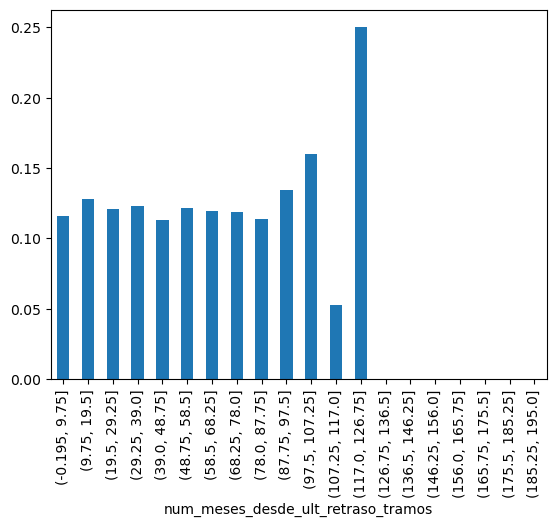

In [18]:
temp.groupby('num_meses_desde_ult_retraso_tramos').target.mean().plot.bar();

La distribución de la target en esta variable no nos genera confianza, así que la descartamos.

In [19]:
num.drop(columns='num_meses_desde_ult_retraso',inplace=True)

En vivienda juntar ANY, NONE y OTHER

In [20]:
cat.vivienda.value_counts()

vivienda
MORTGAGE    68059
RENT        55427
OWN         15507
ANY            53
OTHER           9
NONE            2
Name: count, dtype: int64

In [21]:
cat.vivienda = cat.vivienda.replace(['ANY','NONE','OTHER'],'MORTGAGE')

In [22]:
cat.vivienda.value_counts()

vivienda
MORTGAGE    68123
RENT        55427
OWN         15507
Name: count, dtype: int64

En finalidad juntar renewable_energy, educational y wedding en 'otros'

In [23]:
cat.finalidad.value_counts()

finalidad
debt_consolidation    79122
credit_card           31413
home_improvement       9045
other                  8458
major_purchase         3184
medical                1669
small_business         1569
car                    1435
vacation               1009
moving                  969
house                   953
wedding                 133
renewable_energy         71
educational              27
Name: count, dtype: int64

In [24]:
cat.finalidad = cat.finalidad.replace(['wedding','educational','renewable_energy'],'otros')

In [25]:
cat.finalidad.value_counts()

finalidad
debt_consolidation    79122
credit_card           31413
home_improvement       9045
other                  8458
major_purchase         3184
medical                1669
small_business         1569
car                    1435
vacation               1009
moving                  969
house                   953
otros                   231
Name: count, dtype: int64

## TRANSFORMACIÓN DE CATEGÓRICAS

### One Hot Encoding

#### Variables a aplicar OHE

In [26]:
var_ohe = [ 'ingresos_verificados', 'vivienda','finalidad','num_cuotas']

#### Instanciar

In [27]:
ohe = OneHotEncoder(sparse = False, handle_unknown='ignore')

TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

#### Entrenar y aplicar

In [ ]:
cat_ohe = ohe.fit_transform(cat[var_ohe])

#### Guardar como dataframe

In [ ]:
cat_ohe = pd.DataFrame(cat_ohe, columns = ohe.get_feature_names_out())

### Ordinal Encoding

#### Variables a aplicar OE

In [ ]:
var_oe = ['antigüedad_empleo','rating']

#### Orden de los valores de las variables

In [ ]:
#Orden de la primera variable
orden_antigüedad_empleo = ['desconocido','< 1 year','1 year','2 years','3 years','4 years',
                           '5 years','6 years','7 years','8 years','9 years','10+ years']

#Orden de la segunda variable
orden_rating = ['A','B','C','D','E','F','G']

#### Instanciar

In [ ]:
oe = OrdinalEncoder(categories = [orden_antigüedad_empleo,orden_rating],
                    handle_unknown = 'use_encoded_value',
                    unknown_value = 12)

#### Entrenar y aplicar

In [ ]:
cat_oe = oe.fit_transform(cat[var_oe])

#### Guardar como dataframe

In [ ]:
#Añadir sufijos a los nombres
nombres_oe = [variable + '_oe' for variable in var_oe]

#Guardar como dataframe
cat_oe = pd.DataFrame(cat_oe, columns = nombres_oe)

### Fechas y textos

Cargamos stopwords y limpiamos

In [ ]:
stop = pd.read_csv(ruta_proyecto + '/01_Documentos/stop_words_english.txt',names = ['termino'])

def quitar_tildes(palabra):
    #Definimos la versión con tildes y símbolos y la sin
    con = 'áéíóúüñÁÉÍÓÚÜÑ'
    sin = 'aeiouunAEIOUUN'
    #Creamos un traductor
    traductor = str.maketrans(con,sin)
    #Aplicamos el traductor y devolvemos la palabra limpia
    return(palabra.translate(traductor))

stop['limpias'] = stop.termino.transform(quitar_tildes)

Aplicamos tf-idf.

In [ ]:
#Instanciamos
tfidf = TfidfVectorizer(strip_accents = 'unicode',
                     stop_words = stop.limpias.to_list(),
                     max_df = 0.7,
                     min_df = 50,
                     ngram_range = (1,3),
                     max_features = 50)

#Entrenamos y aplicamos
descripcion = tfidf.fit_transform(cat.descripcion)

In [ ]:
tfidf.vocabulary_

No parece que estos términos puedan generar información adicional a lo que tenemos, así que no incluiremos esta variable en los modelos.

## TRANSFORMACIÓN DE NUMÉRICAS

### Binarizar variables

#### Variables a binarizar

In [ ]:
var_bin = ['num_derogatorios']

#### Instanciar

In [ ]:
bin = Binarizer(threshold=0)

#### Entrenar y aplicar

In [ ]:
num_bin = bin.fit_transform(num[var_bin])

#### Guardar como dataframe

In [ ]:
#Añadir sufijos a los nombres
nombres_bin = [variable + '_bin' for variable in var_bin]

#Guardar como dataframe
num_bin = pd.DataFrame(num_bin,columns = nombres_bin)

## REESCALAR VARIABLES

### Con Min-Max

Unificar los datasets a reescalar.

In [ ]:
num_escalar = num[['ingresos',
                  'dti',
                  'num_lineas_credito',
                  'porc_uso_revolving',
                  'principal',
                  'tipo_interes',
                  'imp_cuota']].reset_index(drop=True)

In [ ]:
df_res = pd.concat([cat_oe,num_escalar], axis=1)

#### Variables a reescalar con Min-Max

In [ ]:
var_mms = df_res.columns

#### Instanciar

In [ ]:
mms = MinMaxScaler()

#### Entrenar y aplicar

In [ ]:
df_mms = mms.fit_transform(df_res[var_mms])

#### Guardar como dataframe

In [ ]:
#Añadir sufijos a los nombres
nombres_mms = [variable + '_mms' for variable in var_mms]

#Guardar como dataframe
df_mms = pd.DataFrame(df_mms,columns = nombres_mms)

## UNIFICAR DATASETS

### Crear una lista con los dataframes y variables a incluir en el tablón analítico para el modelo de PD

In [ ]:
incluir_pd = [cat_ohe, cat_oe, df_mms, num_bin, cat.reset_index()[['id_cliente','target_pd']]]

### Unir todos los dataframes en el tablón analítico para el modelo de PD

In [ ]:
df_pd = pd.concat(incluir_pd, axis = 1)

In [ ]:
df_pd.set_index('id_cliente',inplace=True)

### Crear una lista con los dataframes y variables a incluir en el tablón analítico para el modelo de EAD

In [ ]:
incluir_ead = [cat_ohe, cat_oe, df_mms, num_bin, num.reset_index()[['id_cliente','target_ead']]]

### Unir todos los dataframes en el tablón analítico para el modelo de EAD

In [ ]:
df_ead = pd.concat(incluir_ead, axis = 1)

In [ ]:
df_ead.set_index('id_cliente',inplace=True)

### Crear una lista con los dataframes y variables a incluir en el tablón analítico para el modelo de LGD

In [ ]:
incluir_lgd = [cat_ohe, cat_oe, df_mms, num_bin, num.reset_index()[['id_cliente','target_lgd']]]

### Unir todos los dataframes en el tablón analítico para el modelo de LGD

In [ ]:
df_lgd = pd.concat(incluir_lgd, axis = 1)

In [ ]:
df_lgd.set_index('id_cliente',inplace=True)

## GUARDAR DATASETS TRAS TRANSFORMACIÓN DE DATOS

En formato pickle para no perder las modificaciones de metadatos.

In [ ]:
#Definir los nombres de los archivos
ruta_df_tablon_pd = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'df_tablon_pd.pickle'
ruta_df_tablon_ead = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'df_tablon_ead.pickle'
ruta_df_tablon_lgd = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'df_tablon_lgd.pickle'

In [ ]:
#Guardar los archivos
df_pd.to_pickle(ruta_df_tablon_pd)
df_ead.to_pickle(ruta_df_tablon_ead)
df_lgd.to_pickle(ruta_df_tablon_lgd)